<div style="widelta_th: 100%; overflow: hidden;">
    <div style="display: block;margin-left: auto;margin-right: auto; widelta_th: 100%;"><img src="./1.png"  /></div>
    </a>
</div>

<h2 style="font-family:Avantgarde; font-size:2em; text-align: center;">Projeto 1 - Fusão de Informação e Análise de Dados</h2>


<h4 style="font-family:Avantgarde; font-size:1.75em; text-align: center;">Mestrado em Engenharia e Ciência de Dados</h4>
<h4 style="font-family:Avantgarde; font-size:1.3em; text-align: center;">Ano Letivo 2023/2024</h4>

<p style = "font-family:Avantgarde; font-size:1.1em; text-align: center;"> <b>Mariana Lopes Paulino - 2020190448</b></p>
<p style = "font-family:Avantgarde; font-size:1.1em; text-align: center;"> <b>Rui Alexandre Coelho Tapadinhas - 2018283200</b></p>

<p style="font-family:Avantgarde; font-size:1.25em;"> <b> Tarefas </b> </p>
<p style="font-family:Avantgarde; font-size:1em;"> 1. Criar uma função que implementa o modelo dinâmico do robot; </p>
<p style="font-family:Avantgarde; font-size:1em;"> 2. Criar uma função que implementa o modelo de observação; </p>
<p style="font-family:Avantgarde; font-size:1em;"> 3. Criar uma função que representa a aquisição de dados dos sensores; </p>
<p style="font-family:Avantgarde; font-size:1em;"> 4. Criar uma função que implementa o Extended Kalman Filter (EKF); </p>
<p style="font-family:Avantgarde; font-size:1em;"> 5. Criar uma função que implementa o Unscented Kalman Filter (UKF); </p>
<p style="font-family:Avantgarde; font-size:1em;"> 6. Especificar os vários parâmetros dos filtros e de simulação do robot; </p>
<p style="font-family:Avantgarde; font-size:1em;"> 7. Simular o movimento do robot e representar dinamicamente a sua localização, considerando as trajetórias e a elipse indicadas na Figura 1. </p>


<p style="font-family:Avantgarde; font-size:1.15em;"> <b> Informações Relevantes </b> </p>
<p style="font-family:Avantgarde; font-size:1em;"> O robot tem 4 estados no instante k. xk, yk, Φk, vt.  (x, y) é a posição 2D do robot. Φ é a sua orientação e v a sua velocidade. </p>

<p style="font-family:Avantgarde; font-size:1.5em;"> 0. Import Libraries </p>

In [219]:
from math import sqrt, cos, sin, ceil, atan2, pi
import matplotlib.pyplot as plt
import numpy as np
from plotly import graph_objects as go
import pandas as pd
import os
from scipy.linalg import sqrtm, inv
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

<p style="font-family:Avantgarde; font-size:1.5em;"> 
1. Parâmetros dos Filtros e da Simulação do Robot </p>

<p style="font-family:Avantgarde; font-size:1em;"> Nesta primeira secção definimos os parâmetros que vão ser utilizadps globalmente mais tarde nos filtros e na simulação da localização do robot. Na variável Q é definida a variância no eixo do x, no eixo do y, yaw e velocidade. Nesta secção é ainda definido o intervalo de tempo Δt, a velocidade v (m/s), a velocidade angular Φ (rad/s) e o tempo (s) que desejamos para a nossa simulação. Todos estes dados irão ser usados mais tarde uma vez que são parâmetros decisivos para o robot.</p>

In [220]:
# Covariância para Simular UKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) ** 2  
# Variância no eixo do x, eixo do y, yaw, velocidade

R = np.diag([1.0, 1.0]) ** 2
# Observar a covariância da posição x,y  

# Parâmetros da Simulação
# Intervalo de Tempo [s]
delta_t = 0.1  

# Velocidade medida em [m/s]
v = 1.0  

# Velocidade angular medida em [rad/s]
yawrate = 0.1  

# Tempo de Simulação [s]
sim_time = 50.0  

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]], dtype=float)

#  Parametros para Filtro UKF
ALPHA = 0.001
BETA = 2
KAPPA = 0

<p style="font-family:Avantgarde; font-size:1.5em;"> 2. Aquisição de Dados dos Sensores </p>

<p style="font-family:Avantgarde; font-size:1em;"> Nesta etapa do projeto vamos receber o vetor u que vai ter como dados a velocidade e a orientação do robot no instante k. Após a receção desses dados, é necessária a adição de ruído tanto ao GPS como aos dados recebidos como Inputs do instante k em que nos encontramos.</p>

In [221]:
def input():
    u = np.array([[v, yawrate]]).T
    return u

In [222]:
# Ruídos Aplicados

GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

In [223]:
def observation(xTrue, xd, u):

    xTrue = dynamic_motion_model(xTrue, u)

    # add noise to GPS x-y
    zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
    zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
    z = np.array([[zx, zy]])

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = dynamic_motion_model(xd, ud)

    return xTrue, z, xd, ud

<p style="font-family:Avantgarde; font-size:1.5em;"> 3. Modelo Dinâmico </p>

<p style="font-family:Avantgarde; font-size:1em;"> O modelo não linear dinâmico do robot é definido pela expressão: </p>

<p style="font-family:Avantgarde; font-size:1em; text-align: center;"> <b> x(k+1) = A*x(k) + B*u(k) + w(k) </b> </p>

<p style="font-family:Avantgarde; font-size:1em;"> onde x(k) = [x, y, Φ, v] é o vetor de estados, u(k) = [v, Φ] é o vetor de inputs, A é a matriz de transição de estados, B é a matriz de inputs e w(k) é o ruído do processo. </p>


<p style="font-family:Avantgarde; font-size:1em;"> Neste modelo, vai ser criada uma matriz com a dimensão 4x4 onde os elementos da diagonal principal irão ser 1, 1, 1 e 0 respetivamente. Tal como definido em A. </p>

In [224]:
def dynamic_motion_model(x, u):
    yaw = x[2,0]

    A = np.diag([1.0, 1.0, 1.0, 0])
    #print(A)

    B = np.array([[cos(yaw) * delta_t, 0],
                  [sin(yaw) * delta_t, 0],
                  [0.0, delta_t],
                  [1.0, 0.0]])
    #print(B)

    x = A @ x + B @ u

    return x

<p style="font-family:Avantgarde; font-size:1.5em;"> 4. Modelo de Observação </p>

<p style="font-family:Avantgarde; font-size:1em;"> O robot vai seguir um modelo de observação cuja fórmula é dada por: </p>

<p style="font-family:Avantgarde; font-size:1em; text-align: center;"> <b> z(k) = C*x(k) + r(k) </b> </p>

In [225]:
def observation_model(x):

    C = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])

    z = C @ x

    return z

In [226]:
def jacobianaA(x, u):
    v = u[0, 0]
    yaw = x[2,0]
    
    jacobA = np.array([[1, 0, -v * np.sin(yaw) * delta_t, np.cos(yaw) * delta_t],
                   [0, 1, v * np.cos(yaw) * delta_t, np.sin(yaw) * delta_t],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], dtype=float)
    
    return jacobA

In [227]:
def jacobianaC():
    jacobC = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0]], dtype=float)

    return jacobC

In [228]:
def obs_model(x):
    return jacobianaC().dot(x)

<p style="font-family:Avantgarde; font-size:1em;"> Ambos modelos tanto de Observação como Dinâmico foram implementados com base nas fichas práticas e nos dados do enunciado do projeto. </p>

<p style="font-family:Avantgarde; font-size:1.5em;"> 5. Extended Kalman Filter (EKF) </p>

In [229]:
def ekf(x, p, z, u):
    # Predict
    xpred = dynamic_motion_model(x, u)
    jA = jacobianaA(xpred, u)
    ppred = jA.dot(p).dot(jA.T) + Q

    # Atualizar
    jC = jacobianaC()
    zpred = obs_model(xpred)
    y = z.T - zpred
    S = jC.dot(ppred).dot(jC.T) + R
    K = ppred.dot(jC.T).dot(np.linalg.inv(S))
    x = xpred + K.dot(y)
    p = (np.eye(len(x)) - K.dot(jC)).dot(ppred)

    return x, p

In [230]:
def save(hxpred, xpred, hxtrue, xtrue, hxdr, xdr, hz, z):
    hxpred = np.hstack((hxpred, xpred))
    hxtrue = np.hstack((hxtrue, xtrue))
    hxdr = np.hstack((hxdr, xdr))
    hz = np.vstack((hz, z))
    return hxpred, hxtrue, hxdr, hz

In [243]:
%matplotlib inline

def main():
    print('Robot Inicializado')
    
    # Inicializar o tempo a 0
    time = 0.

    # vetor de estados [x, y, yaw, v]
    xpred = np.zeros((4, 1))    
    xtrue = np.zeros((4, 1))    
    ppred = np.eye(4)

    # dead reckoning
    xdr = np.zeros((4, 1))

    # histórico
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xtrue
    hz = np.zeros((1, 2))

    fig = plt.figure()
    fig.show()

    fig = plt.figure()
    fig.show()

    while time <= sim_time:
        time += delta_t

        xtrue, z, xdr, ud = observation(xtrue, xdr, input())
        xpred, ppred = ekf(xpred, ppred, z, ud)
        hxpred = np.hstack((hxpred, xpred))
        hxdr = np.hstack((hxdr, xdr))
        hxtrue = np.hstack((hxtrue, xtrue))
        hz = np.vstack((hz, z))

        """plt.cla()
        plt.plot(hz[:, 0], hz[:, 1], ".g")
        plt.plot(hxtrue[0, :].flatten(),
                    hxtrue[1, :].flatten(), "-b")
        plt.plot(hxdr[0, :].flatten(),
                    hxdr[1, :].flatten(), "-k")
        plt.plot(hxpred[0, :].flatten(),
                    hxpred[1, :].flatten(), "-r")
        plt.axis("equal")
        
        plt.legend(["Observação", "Verdadeiro", "Dead Reckoning", "Predição EKF"])
        plt.grid(True)

        #Guardar todas as iterações na pasta Frames
        if not os.path.exists('frames'):
            os.makedirs('frames')
        filename = f'frames/{int(ceil(time * 10))}.jpeg'
        plt.savefig(filename)
        #imgs.append(filename)

        # Imagem Final
    filename = f'{int(ceil(time * 10))}.jpeg'
    plt.savefig(filename)
        
    plt.pause(0.001)"""

Robot Inicializado


/var/folders/s8/ryzdv1sn1g15nt9h4886lz7m0000gn/T/ipykernel_6831/3486744624.py:24: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/s8/ryzdv1sn1g15nt9h4886lz7m0000gn/T/ipykernel_6831/3486744624.py:27: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



<Figure size 640x480 with 0 Axes>

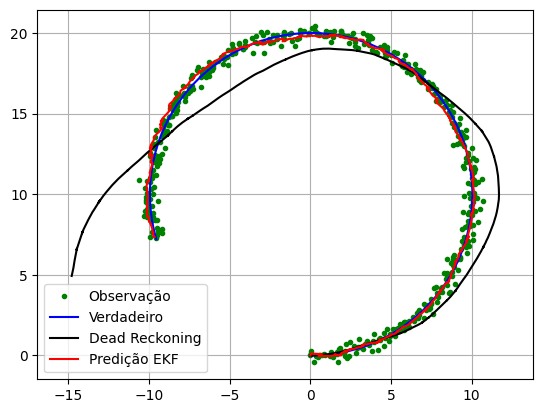

In [244]:
main()

<p style="font-family:Avantgarde; font-size:1em;"> Na secção acima desenvolvemos o Filtro Extended Kalman, guardámos todas as suas iterações dentro dos 50 segundos de tempo de simulação na pasta frames. Assim, conseguimos acompanhar o desenvolvimento da previsão do filtro a cada iteração k que passa. </p>

<p style="font-family:Avantgarde; font-size:1.5em;"> 6. Unscented Kalman Filter (UKF)</p>

In [233]:
def generate_sigma_points(xEst, PEst, gamma):
    sigma = xEst
    Psqrt = sqrtm(PEst)
    n = len(xEst[:, 0])
    # Positive direction
    for i in range(n):
        sigma = np.hstack((sigma, xEst + gamma * Psqrt[:, i:i + 1]))

    # Negative direction
    for i in range(n):
        sigma = np.hstack((sigma, xEst - gamma * Psqrt[:, i:i + 1]))

    return sigma

In [234]:
def predict_sigma_motion(sigma, u):
    """
        Sigma Points prediction with motion model
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = dynamic_motion_model(sigma[:, i:i + 1], u)

    return sigma

In [235]:
def predict_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    for i in range(sigma.shape[1]):
        sigma[0:2, i] = observation_model(sigma[:, i])

    sigma = sigma[0:2, :]

    return sigma

In [236]:
def calc_sigma_covariance(x, sigma, wc, Pi):
    nSigma = sigma.shape[1]
    d = sigma - x[0:sigma.shape[0]]
    P = Pi
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    print(P)
    return P

In [237]:
def calc_pxz(sigma, x, z_sigma, zb, wc):
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T
    
    return P

In [238]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    #  Predict
    sigma = generate_sigma_points(xEst, PEst, gamma)
    sigma = predict_sigma_motion(sigma, u)
    xPred = (wm @ sigma.T).T
    PPred = calc_sigma_covariance(xPred, sigma, wc, Q)

    #  Update
    zPred = observation_model(xPred)
    y = z - zPred
    sigma = generate_sigma_points(xPred, PPred, gamma)
    zb = (wm @ sigma.T).T
    
    z_sigma = predict_sigma_observation(sigma)
    st = calc_sigma_covariance(zb, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)
    K = Pxz @ np.linalg.inv(st)
    xEst = xPred + K @ y
    PEst = PPred - K @ st @ K.T

    return xEst, PEst

In [239]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * pi + 0.1, 0.1)
    a = sqrt(eigval[bigind])
    b = sqrt(eigval[smallind])
    x = [a * cos(it) for it in t]
    y = [b * sin(it) for it in t]
    angle = atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[cos(angle), sin(angle)],
                  [-sin(angle), cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [245]:
def setup_ukf(nx):
    lamb = ALPHA ** 2 * (nx + KAPPA) - nx
    # calculate weights
    wm = [lamb / (lamb + nx)]
    wc = [(lamb / (lamb + nx)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * nx):
        wm.append(1.0 / (2 * (nx + lamb)))
        wc.append(1.0 / (2 * (nx + lamb)))
    gamma = sqrt(nx + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

<p style="font-family:Avantgarde; font-size:1.5em;"> 7. Simulação do Movimento do Robot </p>

<p style="font-family:Avantgarde; font-size:1em;"> Com o desenvolvimento do filtro EKF obtemos como imagem final a que se encontra representada abaixo. Aqui, conseguimos identificar bem todos os traços da mesma. </p>

<div style="widelta_th: 100%; overflow: hidden;">
    <div style="display: block;margin-left: auto;margin-right: auto; widelta_th: 100%;"><img src="./final.jpeg"  /></div>
    </a>

<p style="font-family:Avantgarde; font-size:1em;"> Com o filtro UKF obtemos o desenvolvimento seguinte, onde tabém conseguimos identificar todos os traços necessários à posterior análise de dados.</p>

<p style="font-family:Avantgarde; font-size:1.5em;"> 8. Análise do Erro </p>